In [1]:
%load_ext autoreload
%autoreload
import poisson_hypergraph
import numpy as np
import xgi
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import csv
import seaborn as sns

In [2]:
def e_prime_prob(GH, e_prime_index, theta):
    edges = GH.get_edges()
    e_prime = edges[e_prime_index]
    summation = 0
    for e_index in range(e_prime_index):
        e = edges[e_index]
        for u_index in e.intersection(e_prime):
            summation += GH.likelihood(e_index, u_index, e_prime_index, theta)
    return summation

In [3]:
def p_q_likelihoods(GH, grain, gammas):
    gamma_nu, gamma_nr, gamma_eu, gamma_er = gammas

    edges = GH.get_edges()
    step = 1 / grain

    # P = np.linspace(0 + step, 1 - step, num = grain)
    # Q = np.linspace(0 + step, 1 - step, num = grain)
    P = np.linspace(0, 1, num = grain)
    Q = np.linspace(0, 1, num = grain)
    
    likelihood_values = np.zeros((grain, grain))

    for p_index, p in enumerate(P):
        for q_index, q in enumerate(Q):
            theta = [p, q, gamma_nu, gamma_nr, gamma_eu, gamma_er]
            this_likelihood = 0
            for e_prime_index in range(1, len(edges)):
                this_likelihood += np.log(e_prime_prob(GH, e_prime_index, theta))
            likelihood_values[q_index, p_index] = this_likelihood
    
    q_max, p_max = np.unravel_index(np.argmax(likelihood_values, axis=None), likelihood_values.shape)
    
    return likelihood_values, p_max, q_max

In [4]:
def gamma_ext_likelihoods(GH, grain, other_thetas):
    p, q, gamma_nu, gamma_nr = other_thetas

    edges = GH.get_edges()
    step = 1 / grain

    # GEU = np.linspace(0 + step, 1 - step, num = grain)
    # GER = np.linspace(0 + step, 1 - step, num = grain)
    GEU = np.linspace(0, 1, num = grain)
    GER = np.linspace(0, 1, num = grain)

    likelihood_values = np.zeros((grain, grain))

    for geu_index, gamma_eu in enumerate(GEU):
        for ger_index, gamma_er in enumerate(GER):
            theta = [p, q, gamma_nu, gamma_nr, gamma_eu, gamma_er]
            this_likelihood = 0
            for e_prime_index in range(1, len(edges)):
                this_likelihood += np.log(e_prime_prob(GH, e_prime_index, theta))
            likelihood_values[ger_index, geu_index] = this_likelihood
    
    ger_max, geu_max = np.unravel_index(np.argmax(likelihood_values, axis=None), likelihood_values.shape)
    
    return likelihood_values, geu_max, ger_max

In [5]:
def gamma_new_likelihoods(GH, grain, other_thetas):
    p, q, gamma_eu, gamma_er = other_thetas

    edges = GH.get_edges()
    step = 1 / grain

    # GNU = np.linspace(0 + step, 1 - step, num = grain)
    # GNR = np.linspace(0 + step, 1 - step, num = grain)
    GNU = np.linspace(0, 1, num = grain)
    GNR = np.linspace(0, 1, num = grain)

    likelihood_values = np.zeros((grain, grain))

    for gnu_index, gamma_nu in enumerate(GNU):
        for gnr_index, gamma_nr in enumerate(GNR):
            theta = [p, q, gamma_nu, gamma_nr, gamma_eu, gamma_er]
            this_likelihood = 0
            for e_prime_index in range(1, len(edges)):
                this_likelihood += np.log(e_prime_prob(GH, e_prime_index, theta))
            likelihood_values[gnr_index, gnu_index] = this_likelihood
    
    gnr_max, gnu_max = np.unravel_index(np.argmax(likelihood_values, axis=None), likelihood_values.shape)
    
    return likelihood_values, gnu_max, gnr_max

In [6]:
def generate_hypergraph_big(theta, size):
    H = xgi.Hypergraph([[0, 1], [0, 2, 3, 4], [1, 5, 6, 7, 8]])
    H.set_node_attributes({0 : 0, 1 : 1, 2 : 0, 3 : 1, 4 : 0, 5 : 1, 6 : 0, 7 : 1, 8 : 0}, name = "label")
    GH = poisson_hypergraph.GH(H, [0, 1], theta[0], theta[1])
    GH.add_hyperedge(size, theta[2], theta[3], theta[4], theta[5])
    return GH

In [7]:
def experiment(theta, timesteps, grain):
    p, q, gamma_nu, gamma_nr, gamma_eu, gamma_er = theta
    GH = generate_hypergraph_big(theta, timesteps)

    # get p, q lik values
    lik_values_pq, p_max, q_max = p_q_likelihoods(GH, grain, [gamma_nu, gamma_nr, gamma_eu, gamma_er])

    # get gamma ext lik values
    lik_values_ext, geu_max, ger_max = gamma_ext_likelihoods(GH, grain, [p, q, gamma_nu, gamma_nr])

    # get gamma new lik values
    lik_values_new, gnu_max, gnr_max = gamma_new_likelihoods(GH, grain, [p, q, gamma_eu, gamma_er])


    return lik_values_pq, p_max, q_max, lik_values_ext, geu_max, ger_max, lik_values_new, gnu_max, gnr_max

In [26]:
def make_plot(grain, lik_values_pq, p_max, q_max, lik_values_ext, geu_max, ger_max, lik_values_new, gnu_max, gnr_max, true_theta):

    step = 1/grain

    bins_1 = lik_values_pq.shape[0]
    bins_2 = lik_values_ext.shape[0]
    bins_3 = lik_values_new.shape[0]

    P = np.linspace(0, 1, num = bins_1)
    Q = np.linspace(0, 1, num = bins_1)

    GEU = np.linspace(0, 1, num = bins_2)
    GER = np.linspace(0, 1, num = bins_2)

    GNU = np.linspace(0, 1, num = bins_3)
    GNR = np.linspace(0, 1, num = bins_3)

    vmin = min(np.min(lik_values_pq), np.min(lik_values_ext), np.min(lik_values_new))
    vmax = max(np.max(lik_values_pq), np.max(lik_values_ext), np.max(lik_values_new))

    sns.set_style("whitegrid")
    sns.set_palette("Dark2")

    plt.rcParams.update({'font.size': 17})
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13) 

    fig4, ax4 = plt.subplots(1, 3, sharex = True, sharey = True)
    fig4.set_figwidth(20)
    fig4.set_figheight(9)
    cmap = cm['viridis']
    cmap.set_bad('black',1.)

    plt.xlim(0, 1)

    im1 = ax4[0].imshow(lik_values_pq, cmap=cmap, interpolation='nearest', origin = "lower", vmin = vmin, vmax = vmax)
    ax4[0].set_xticks(ticks = np.linspace(0, 1, 11)*bins_1, labels = np.round(np.linspace(0, 1, 11), 2))
    ax4[0].set_yticks(ticks = np.linspace(0, 1, 11)*bins_1, labels = np.round(np.linspace(0, 1, 11), 2))
    ax4[0].set_xlabel("p")
    ax4[0].set_ylabel("q")
    ax4[0].scatter([true_theta[0] * grain], [true_theta[1] * grain], zorder = 100, color = 'C0', edgecolors="black")
    ax4[0].scatter([p_max], [q_max], zorder = 100, color = 'C1', edgecolors="black")
    ax4[0].contour(np.linspace(0, lik_values_pq.shape[0], num = bins_1), np.linspace(0, lik_values_pq.shape[0], num = bins_1), lik_values_pq, 
                   levels = 20, colors = "white", linestyles = "solid")
    ax4[0].set_title(r"$\hat{p} = $" + f"{P[p_max]:.2f}" + "  |  " r"$\hat{q} = $" + f"{Q[q_max]:.2f}")


    im2 = ax4[1].imshow(lik_values_ext, cmap=cmap, interpolation='nearest', origin = "lower", vmin = vmin, vmax = vmax)
    ax4[1].set_xlabel("$\\hat{\\gamma}_{e, z_u}$")
    ax4[1].set_ylabel("$\\hat{\\gamma}_{e, \\bar{z}_u}$")
    ax4[1].scatter([true_theta[4] * grain], [true_theta[5] * grain], zorder = 100, color = 'C0', edgecolors="black")
    ax4[1].scatter([geu_max], [ger_max], zorder = 100, color = 'C1', edgecolors="black")
    ax4[1].contour(np.linspace(0, lik_values_ext.shape[0], num = bins_1), np.linspace(0, lik_values_ext.shape[0], num = bins_1), lik_values_ext, 
                   levels = 20, colors = "white", linestyles = "solid")
    ax4[1].set_title(r"$\hat{\gamma}_{e, z_u} = $" + f"{GEU[geu_max]:.2f}" + "  |  " r"$\hat{\gamma}_{e, \bar{z}_u} = $" + f"{GER[ger_max]:.2f}")

    im3 = ax4[2].imshow(lik_values_new, cmap=cmap, interpolation='nearest', origin = "lower", vmin = vmin, vmax = vmax)
    ax4[2].set_xlabel("$\\hat{\\gamma}_{n, z_u}$")
    ax4[2].set_ylabel("$\\hat{\\gamma}_{n, \\bar{z}_u}$")
    ax4[2].scatter([true_theta[2] * grain], [true_theta[3] * grain], zorder = 100, color = 'C0', edgecolors="black")
    ax4[2].scatter([gnu_max], [gnr_max], zorder = 100, color = 'C1', edgecolors="black")
    ax4[2].contour(np.linspace(0, lik_values_new.shape[0], num = bins_1), np.linspace(0, lik_values_new.shape[0], num = bins_1), lik_values_new, 
                   levels = 20, colors = "white", linestyles = "solid")
    ax4[2].set_title(r"$\hat{\gamma}_{n, z_u} = $" + f"{GNU[gnu_max]:.2f}" + "  |  " r"$\hat{\gamma}_{n, \bar{z}_u} = $" + f"{GNR[gnr_max]:.2f}")

    cbar_ax = fig4.add_axes([0.22, 0.10, 0.56, 0.05])
    fig4.colorbar(im1, cax=cbar_ax, orientation='horizontal', label = "Log marginal likelihood")


    fig4.savefig('sem_explanatory.png', dpi=300,  bbox_inches="tight")
    
    plt.show()

In [217]:
# lik_values_pq, p_max, q_max, lik_values_ext, geu_max, ger_max, lik_values_new, gnu_max, gnr_max = experiment([0.6, 0.4, 0.75, 0.25, 0.5, 0.5], 500, 50)

In [222]:
# with open('explanatory_data_pq.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(lik_values_pq)

# with open('explanatory_data_ext.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(lik_values_ext)

# with open('explanatory_data_new.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(lik_values_new)

In [10]:
lik_values_pq = []
with open('/Users/violetross/Desktop/Thesis/Figures-Code/SEM/explanatory_data_pq.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        lik_values_pq.append(row)
lik_values_pq = np.array(lik_values_pq).astype(float)

lik_values_ext = []
with open('/Users/violetross/Desktop/Thesis/Figures-Code/SEM/explanatory_data_ext.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        lik_values_ext.append(row)
lik_values_ext = np.array(lik_values_ext).astype(float)

lik_values_new = []
with open('/Users/violetross/Desktop/Thesis/Figures-Code/SEM/explanatory_data_new.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        lik_values_new.append(row)
lik_values_new = np.array(lik_values_new).astype(float)

In [12]:
q_max, p_max = np.unravel_index(np.argmax(lik_values_pq, axis=None), lik_values_pq.shape)
ger_max, geu_max = np.unravel_index(np.argmax(lik_values_ext, axis=None), lik_values_ext.shape)
gnr_max, gnu_max = np.unravel_index(np.argmax(lik_values_new, axis=None), lik_values_new.shape)

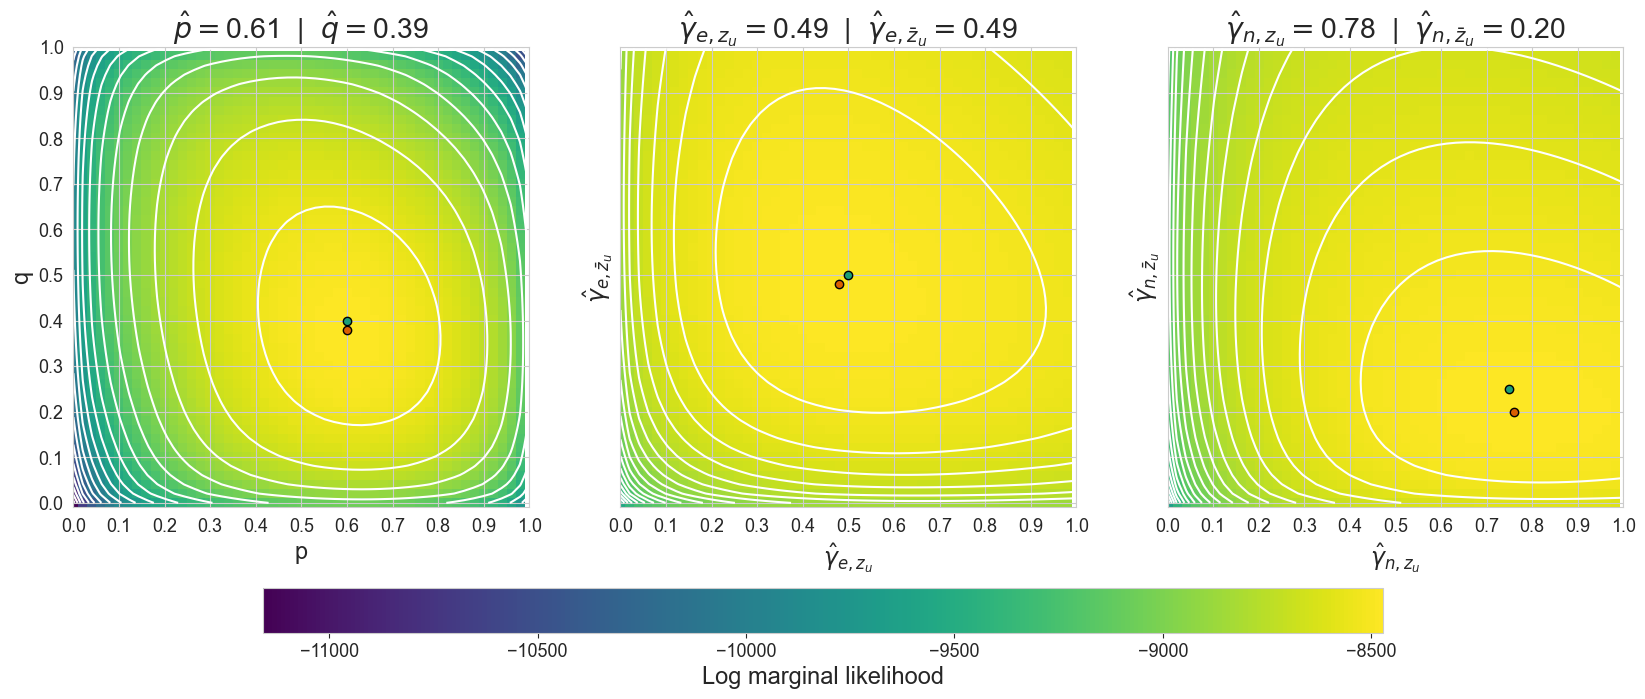

In [27]:
make_plot(50, lik_values_pq, p_max, q_max, lik_values_ext, geu_max, ger_max, lik_values_new, gnu_max, gnr_max, [0.6, 0.4, 0.75, 0.25, 0.5, 0.5])